### - Sobhan Moradian Daghigh
#### - 5/29/2022
#### - ANN - HW06

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import urllib
import pickle
from sklearn.metrics import confusion_matrix

import tensorflow as tf, keras
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, LSTM, Dropout

import warnings
warnings.filterwarnings("ignore")

import itertools

%load_ext tensorboard

In [2]:
print(tf.__version__)

2.8.0


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
tb_callback = keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/logs', histogram_freq=1)

In [5]:
class EarlyStoppingCallback(keras.callbacks.Callback):
  def __init__(self, patience=0):
    super(EarlyStoppingCallback, self).__init__()
    self.patience = patience

  def on_train_begin(self, logs=None):
    self.best = np.inf
    self.wait = 0
  
  def on_epoch_end(self, epoch, logs=None):
    current_loss = logs.get('loss')
    if np.less(current_loss, self.best):
      self.best = current_loss
      self.wait = 0
      self.best_weights = self.model.get_weights()
    else:
      self.wait += 1
      if np.greater_equal(self.wait, self.patience):
        self.model.stop_training = True
        self.model.set_weights(self.best_weights)

In [6]:
es_callback = EarlyStoppingCallback(patience=3)

# Load Data

In [62]:
def load_data(base_url):
  merged_data = pd.DataFrame(columns=['<DTYYYYMMDD>'])
  file_names = []
  total_index_csv = None

  with urllib.request.urlopen(base_url + 'names.txt') as names:
    idx = 0
    for name in names.readlines():
      name = name.decode("utf-8").split('\n')[0]
      data = pd.read_csv(base_url + name, delimiter=',', encoding='utf-16_le')
      if not data.empty:
        data = pd.DataFrame(data[(data['<DTYYYYMMDD>'] > 20210522)], columns=data.columns).reset_index(drop=True) # Filter 1 year
        drop_attrs = [0, 10, 11] # Drop attrs: <TICKER>, <COl12>, <COl13>
        data.drop(data.columns[drop_attrs], axis=1, inplace=True)
        
        if name != 'IRX6XTPI0009.csv':
          merged_data = pd.merge(merged_data, data, left_on='<DTYYYYMMDD>', right_on='<DTYYYYMMDD>', how="right", sort=False)
        else:
          total_index_csv = data

        file_names.append(name)
        print('   |_ {}- {} loaded.'.format(idx, name))
        idx += 1

  return merged_data, total_index_csv, file_names

In [63]:
base_url = 'https://raw.githubusercontent.com/nahbos/AUT-Neural-Networks/main/HW06/dataset/'
merged_data, total_index_csv, names = load_data(base_url)

   |_ 0- IRX6XAFF0005.csv loaded.
   |_ 1- IRX6XALS0002.csv loaded.
   |_ 2- IRX6XS300003.csv loaded.
   |_ 3- IRX6XSLC0000.csv loaded.
   |_ 4- IRX6XSNT0009.csv loaded.
   |_ 5- IRX6XTAL0001.csv loaded.
   |_ 6- IRX6XTPI0009.csv loaded.
   |_ 7- IRX6XTPI0025.csv loaded.
   |_ 8- IRX6XWAI0001.csv loaded.
   |_ 9- IRXYXTPI0009.csv loaded.
   |_ 10- IRXYXTPI0025.csv loaded.
   |_ 11- IRXZXCMI0000.csv loaded.
   |_ 12- IRXZXENG0009.csv loaded.
   |_ 13- IRXZXOCI0008.csv loaded.
   |_ 14- IRXZXTRI0006.csv loaded.
   |_ 15- IRXZXWDI0007.csv loaded.


In [64]:
# merged_data[merged_data.isna().any(axis=1)].iloc[0, :]

In [65]:
merged_data.shape

(237, 136)

In [66]:
total_index_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   <DTYYYYMMDD>  237 non-null    int64  
 1   <OPEN>        237 non-null    float64
 2   <HIGH>        237 non-null    float64
 3   <LOW>         237 non-null    float64
 4   <CLOSE>       237 non-null    float64
 5   <VOL>         237 non-null    int64  
 6   <OPENINT>     237 non-null    float64
 7   <OPENINT>.1   237 non-null    int64  
 8   <OPENINT>.2   237 non-null    float64
 9   <LAST>        237 non-null    float64
dtypes: float64(7), int64(3)
memory usage: 18.6 KB


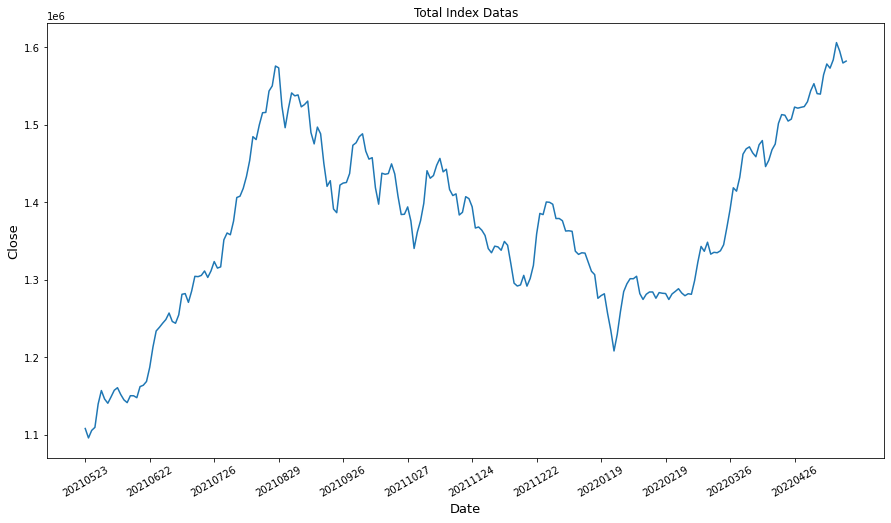

In [67]:
plt.figure(figsize = (15, 8))
plt.plot(range(total_index_csv.shape[0]), total_index_csv['<CLOSE>'])
plt.xticks(range(0, total_index_csv.shape[0], 20), total_index_csv['<DTYYYYMMDD>'].loc[::20], rotation=30)
plt.title('Total Index Datas')
plt.xlabel('Date', fontsize=13)
plt.ylabel('Close', fontsize=13)
plt.show()

## Data Normalization

In [68]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = pd.DataFrame(scaler.fit_transform(merged_data), columns=merged_data.columns)

## Define time steps

In [137]:
x_timesteps = []
y_timesteps = []
timesteps_size = 25

for i in range(data_scaled.shape[0] - timesteps_size):
  x_timesteps.append(data_scaled.to_numpy()[i:i + timesteps_size, :])

  if total_index_csv.loc[i + timesteps_size, '<CLOSE>'] > total_index_csv.loc[i + timesteps_size - 1, '<CLOSE>']:
    y_timesteps.append(1)
  else:
    y_timesteps.append(0)

x_train_val_timesteps, y_train_val_timesteps = np.array(x_timesteps), np.array(y_timesteps)
x_train_val_timesteps = np.reshape(x_train_val_timesteps, (x_train_val_timesteps.shape[0], x_train_val_timesteps.shape[1], data_scaled.shape[1]))

x_temp, x_test, y_temp, y_test = train_test_split(x_train_val_timesteps, y_train_val_timesteps, test_size=0.2, random_state=0, stratify=y_train_val_timesteps)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.125, random_state=0, stratify=y_temp)

In [144]:
np.unique(y_train_val_timesteps, return_counts=True)

(array([0, 1]), array([ 92, 120]))

In [139]:
x_train.shape

(147, 25, 136)

In [140]:
x_val.shape

(22, 25, 136)

In [141]:
x_test.shape

(43, 25, 136)

In [142]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([63, 84]))

In [148]:
label_0 = np.unique(y_train, return_counts=True)[1][0]
label_1 = np.unique(y_train, return_counts=True)[1][1]

print('Labels percentages in Train dataset:')
print('   |_ 0: {} %'.format(round(label_0/len(y_train), 2)))
print('   |_ 1: {} %'.format(round(label_1/len(y_train), 2)))

Labels percentages in Train dataset:
   |_ 0: 0.43 %
   |_ 1: 0.57 %


In [149]:
label_0 = np.unique(y_test, return_counts=True)[1][0]
label_1 = np.unique(y_test, return_counts=True)[1][1]

print('Labels percentages in Test dataset:')
print('   |_ 0: {} %'.format(round(label_0/len(y_test), 2)))
print('   |_ 1: {} %'.format(round(label_1/len(y_test), 2)))

Labels percentages in Test dataset:
   |_ 0: 0.44 %
   |_ 1: 0.56 %


## LSTM

In [171]:
# model = Sequential()
# model.add(LSTM(units=20, return_sequences=True, input_shape = (x_train.shape[1], x_train.shape[2])))
# model.add(Dropout(0.1)) 
# model.add(LSTM(units=10))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(units=80, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.15))
model.add(LSTM(units=30,return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=15))
model.add(Dense(units=1))

In [172]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 25, 80)            69440     
                                                                 
 dropout_19 (Dropout)        (None, 25, 80)            0         
                                                                 
 lstm_29 (LSTM)              (None, 25, 50)            26200     
                                                                 
 dropout_20 (Dropout)        (None, 25, 50)            0         
                                                                 
 lstm_30 (LSTM)              (None, 25, 30)            9720      
                                                                 
 dropout_21 (Dropout)        (None, 25, 30)            0         
                                                                 
 lstm_31 (LSTM)              (None, 15)              

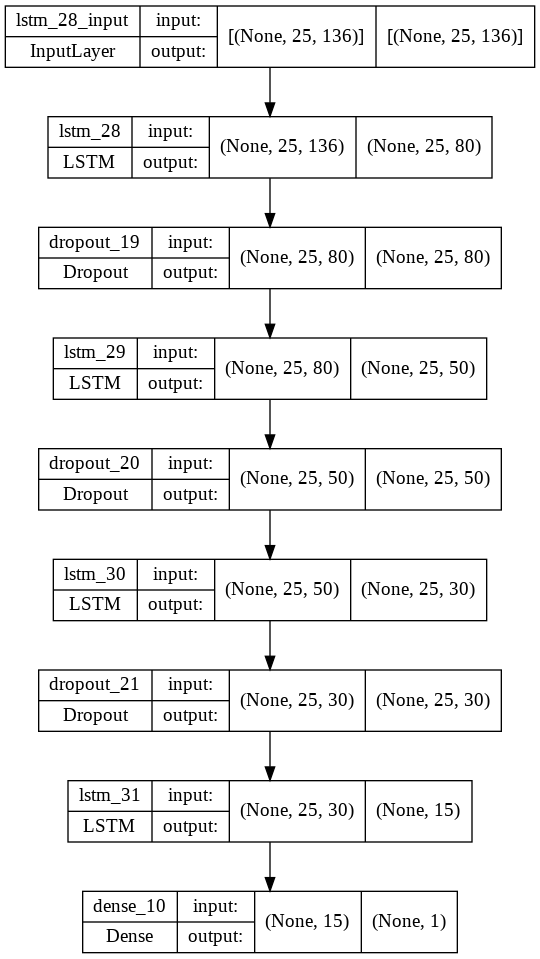

In [173]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [ ]:
model.fit(x_train, y_train, batch_size=16, epochs=100, validation_data=(x_val, y_val), callbacks=[tb_callback])

Epoch 1/100
10/10 [==============================] - 84s 293ms/step - loss: 1.3518 - accuracy: 0.4898 - val_loss: 0.7168 - val_accuracy: 0.5455
Epoch 2/100
10/10 [==============================] - 1s 72ms/step - loss: 0.7045 - accuracy: 0.5442 - val_loss: 0.6902 - val_accuracy: 0.5455
Epoch 3/100
10/10 [==============================] - 1s 70ms/step - loss: 0.6853 - accuracy: 0.5918 - val_loss: 0.7014 - val_accuracy: 0.5455
Epoch 4/100
10/10 [==============================] - 1s 69ms/step - loss: 0.6871 - accuracy: 0.5714 - val_loss: 0.6960 - val_accuracy: 0.5455
Epoch 5/100
10/10 [==============================] - 1s 66ms/step - loss: 0.6717 - accuracy: 0.5782 - val_loss: 0.6908 - val_accuracy: 0.5909
Epoch 6/100
10/10 [==============================] - 1s 69ms/step - loss: 0.6824 - accuracy: 0.5578 - val_loss: 0.6913 - val_accuracy: 0.5455
Epoch 7/100
10/10 [==============================] - 1s 74ms/step - loss: 0.6862 - accuracy: 0.5646 - val_loss: 0.6920 - val_accuracy: 0.5455
Epoc

In [ ]:
model.evaluate(x_test, y_test, verbose=1)

In [ ]:
%tensorboard --logdir '/content/drive/MyDrive/logs'

# Confusion Matrix

In [160]:
y_pred = model.predict(x_test)
oo = [1 if x > 0.5 else 0 for x in y_pred]
confusion_matrix(y_test, oo)

array([[ 6, 13],
       [ 5, 19]])

## GRU

In [161]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(50, return_sequences=True, input_shape=(20, 320), activation='tanh'))
model.add(tf.keras.layers.GRU(50, activation='tanh'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False), loss='binary_crossentropy')
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 50)            55800     
                                                                 
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71,151
Trainable params: 71,151
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# filename = '/content/drive/MyDrive/model2.sav'
# pickle.dump(model, open(filename, 'wb'))

In [110]:
# loaded_model = pickle.load(open(filename, 'rb'))